In [ ]:
!apt install swig cmake

In [ ]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt

In [ ]:
!sudo apt-get update
!sudo apt-get install -y python3-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

In [ ]:
import os
os.kill(os.getpid(), 9)

## Extra

In [ ]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
import gymnasium

from huggingface_sb3 import load_from_hub, package_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

# Start

## reference of a working env

In [1]:
import gymnasium as gym
env = gym.make("LunarLander-v2")

In [ ]:
n_games = 100

for i in range(n_games):
  obs = env.reset()
  score = 0
  done = False
  truncated = False
  while not (done | truncated):
    action = env.action_space.sample()
    obs_, reward, done, truncated, info = env.step(action)
    score += reward


  print('Episode ', i, 'score %.1f' %score)

## Policy

In [2]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

NN for the policy

In [4]:
class PolicyNetwork(nn.Module):
  def __init__(self, lr, input_dims,hidden_dims, n_actions):
    super(PolicyNetwork, self).__init__()
    '''
    self.fc1 = nn.Linear(*input_dims, hidden_dims)
    self.fc2 = nn.Linear(hidden_dims, hidden_dims)
    self.fc3 = nn.Linear(hidden_dims, n_actions)
    '''
    self.fc1 = nn.Linear(*input_dims, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, n_actions)
    self.optimizer = optim.Adam(self.parameters(), lr=lr)

    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

## Policy Gradient

In [5]:
class PolicyGradient():
  def __init__(self, lr, input_dims,hidden_dims, gamma = 0.99, n_actions=4):
    self.gamma = gamma
    self.lr = lr
    self.reward_memory = []
    self.action_memory = []

    self.policy = PolicyNetwork(self.lr, input_dims, hidden_dims, n_actions)

  def choose_action(self, observation):
    state = T.tensor([observation]).to(self.policy.device)
    probs = F.softmax(self.policy.forward(state))
    action_probs = T.distributions.Categorical(probs)
    action = action_probs.sample()
    log_probs = action_probs.log_prob(action)
    self.action_memory.append(log_probs)

    return action.item()

  def store_rewards(self, reward):
    self.reward_memory.append(reward)

  def learn(self):
    self.policy.optimizer.zero_grad()

    G = np.zeros_like(self.reward_memory, dtype=np.float64)

    # Below for in for loop is the reason for the delay in the code
    '''Replace it by
    G = np.zeros_like(self.reward_memory, dtype=np.float64)
    discounts = np.logspace(0, len(self.reward_memory)-1, num=len(self.reward_memory), base=self.gamma, endpoint=False)
    G = np.flip(np.cumsum(np.flip(self.reward_memory * discounts)))
    '''

    for t in range(len(self.reward_memory)):

      G_sum = 0
      discount = 1
      for k in range(t, len(self.reward_memory)):
        G_sum += self.reward_memory[k] * discount
        discount *= self.gamma

      G[t] = G_sum

    G = T.tensor(G, dtype = T.float).to(self.policy.device)

    loss = 0
    for g, logprob in zip(G, self.action_memory):
      loss += -g * logprob
    loss.backward()
    self.policy.optimizer.step()

    self.action_memory = []
    self.reward_memory = []

In [6]:
class PolicyGradient():
  def __init__(self, lr, input_dims,hidden_dims, gamma = 0.99, n_actions=4):
    self.gamma = gamma
    self.lr = lr
    self.reward_memory = []
    self.action_memory = []

    self.policy = PolicyNetwork(self.lr, input_dims, hidden_dims, n_actions)

  def choose_action(self, observation):
    state = T.tensor([observation]).to(self.policy.device)
    probs = F.softmax(self.policy.forward(state))
    action_probs = T.distributions.Categorical(probs)
    action = action_probs.sample()
    log_probs = action_probs.log_prob(action)
    self.action_memory.append(log_probs)

    return action.item()

  def store_rewards(self, reward):
    self.reward_memory.append(reward)

  def learn(self):
    self.policy.optimizer.zero_grad()

    G = np.zeros_like(self.reward_memory, dtype=np.float64)
    discounts = np.logspace(0, len(self.reward_memory)-1, num=len(self.reward_memory), base=self.gamma, endpoint=False)
    G = np.flip(np.cumsum(np.flip(self.reward_memory * discounts)))

    G = T.tensor(np.copy(G), dtype = T.float).to(self.policy.device)

    loss = 0
    for g, logprob in zip(G, self.action_memory):
      loss += -g * logprob
    loss.backward()
    self.policy.optimizer.step()

    self.action_memory = []
    self.reward_memory = []

In [19]:
class PolicyGradientAgent():
    def __init__(self, lr, input_dims, gamma=0.99, n_actions=4):
        self.gamma = gamma
        self.lr = lr
        self.reward_memory = []
        self.action_memory = []

        self.policy = PolicyNetwork(self.lr, input_dims, n_actions)

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.policy.device)
        probs = F.softmax(self.policy.forward(state))
        action_probs = T.distributions.Categorical(probs)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        self.action_memory.append(log_probs)

        return action.item()

    def store_rewards(self, reward):
        self.reward_memory.append(reward)

    def learn(self):
        self.policy.optimizer.zero_grad()

        rewards = T.tensor(self.reward_memory, dtype=T.float).to(self.policy.device)
        discounts = T.pow(self.gamma, T.arange(len(rewards), dtype=T.float).to(self.policy.device))
        G = T.flip(T.cumsum(T.flip(rewards * discounts)))

        loss = -T.sum(G * T.cat(self.action_memory))
        loss.backward()
        self.policy.optimizer.step()

        self.action_memory = []
        self.reward_memory = []


### Some info on Policy Gradient

Here action_probs contains the prob of choosing action

And using sample, action (index) is given out acc to that policy

sample gives action(index) according to the probability

further for each action loss is calculated (time_step) (G[t] as g in loss and logprob (action.log_prob(action))

With this we are


In [ ]:
import numpy as np

In [ ]:
G = np.array([1,1,1])
print(G)
dis = np.logspace(0, 2, num=3, base = 0.9, endpoint = False)
print(f"dis: {dis}")
G_ = (np.cumsum((G*dis)))
print(f"New G: {G_}")
T = (G*dis)
print(f"T: {T}")
S = [1,2,3,4]
print(f"S: {S}")
R = np.cumsum(S)
print(f"R: {R}")

[1 1 1]
dis: [1.         0.93216975 0.86894045]
New G: [1.         1.93216975 2.8011102 ]
T: [1.         0.93216975 0.86894045]
S: [1, 2, 3, 4]
R: [ 1  3  6 10]


In [ ]:
for t in range(len(G)):

  G_sum = 0
  discount = 1
  for k in range(t, len(G)):
    G_sum += G[k] * discount
    discount *= 0.9

  G[t] = G_sum
print(G)

[3 1 1]


In [ ]:
pribs = T.tensor([0.3, 0.4, 0.3])
act_pribs = T.distributions.Categorical(pribs)

# Sample from the categorical distribution
sampled_action = act_pribs.sample()

# Access the probabilities associated with each category
action_probs = act_pribs.probs

print("Sampled Action:", sampled_action.item())
print("Action Probabilities:", action_probs)

Sampled Action: 0
Action Probabilities: tensor([0.3000, 0.4000, 0.3000])


In [ ]:
pribs = T.tensor([0.3, 0.4, 0.3])
act_pribs = T.distributions.Categorical(pribs)

# Sample from the categorical distribution
sampled_action = act_pribs.sample()

# Access the probabilities associated with each category
action_probs = act_pribs.probs

print("Sampled Action:", sampled_action.item())
print("Action Probabilities:", action_probs)

Sampled Action: 2
Action Probabilities: tensor([0.3000, 0.4000, 0.3000])


In [ ]:
pribs = T.tensor([0.1,0.2, 0.4, 0.3])
act_pribs = T.distributions.Categorical(pribs)

# Sample from the categorical distribution
sampled_action = act_pribs.sample()

# Access the probabilities associated with each category
action_probs = act_pribs.probs

print("Sampled Action:", sampled_action.item())
print("Action Probabilities:", action_probs)

Sampled Action: 1
Action Probabilities: tensor([0.1000, 0.2000, 0.4000, 0.3000])


## Continued

In [24]:
env = gym.make('LunarLander-v2')
n_games = 3000
agent = PolicyGradient(gamma = 0.99, lr = 0.0005,hidden_dims = 128,
                       input_dims = [8], n_actions = 4)

scores = []

for i in range(n_games):
  done = False
  obs, info = env.reset()
  print(type(obs))
  score = 0
  while not done:
    action = agent.choose_action(obs)
    obs_, reward, done, truncated, info = env.step(action)
    score += reward
    agent.store_rewards(reward)
    obs = obs_
  agent.learn()
  scores.append(score)

  avg_score = np.mean(scores[-100:])
  print('episode ', i, 'score %.2f' % score,
        'average score %.2f' % avg_score)

<class 'numpy.ndarray'>


<ipython-input-6-c9dbb6669183>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.policy.forward(state))


episode  0 score -117.29 average score -117.29
<class 'numpy.ndarray'>
episode  1 score -249.08 average score -183.19
<class 'numpy.ndarray'>
episode  2 score -159.78 average score -175.38
<class 'numpy.ndarray'>
episode  3 score -155.37 average score -170.38
<class 'numpy.ndarray'>
episode  4 score -109.70 average score -158.24
<class 'numpy.ndarray'>
episode  5 score -157.30 average score -158.09
<class 'numpy.ndarray'>
episode  6 score -147.21 average score -156.53
<class 'numpy.ndarray'>
episode  7 score -262.80 average score -169.82
<class 'numpy.ndarray'>
episode  8 score -103.74 average score -162.48
<class 'numpy.ndarray'>
episode  9 score -330.42 average score -179.27
<class 'numpy.ndarray'>
episode  10 score -372.12 average score -196.80
<class 'numpy.ndarray'>
episode  11 score -190.21 average score -196.25
<class 'numpy.ndarray'>
episode  12 score -78.71 average score -187.21
<class 'numpy.ndarray'>
episode  13 score -194.03 average score -187.70
<class 'numpy.ndarray'>
epi

KeyboardInterrupt: ignored

In [8]:
env = gym.make('LunarLander-v2')
n_games = 3000
agent = PolicyGradient(gamma = 0.99, lr = 0.0005,hidden_dims = 128,
                       input_dims = [8], n_actions = 4)

scores = []

for i in range(n_games):
  done = False
  obs, info = env.reset()
  print(type(obs))
  score = 0
  while not done:
    action = agent.choose_action(obs)
    obs_, reward, done, truncated, info = env.step(action)
    score += reward
    agent.store_rewards(reward)
    obs = obs_
  agent.learn()
  scores.append(score)

  print('episode ', i, 'score %.2f' % score)

<class 'numpy.ndarray'>
episode  0 score -162.57
<class 'numpy.ndarray'>


<ipython-input-6-c9dbb6669183>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.policy.forward(state))


Streaming output truncated to the last 5000 lines.
episode  188 score -107.70
<class 'numpy.ndarray'>
episode  189 score -206.52
<class 'numpy.ndarray'>
episode  190 score -125.52
<class 'numpy.ndarray'>
episode  191 score -68.42
<class 'numpy.ndarray'>
episode  192 score -123.31
<class 'numpy.ndarray'>
episode  193 score -122.62
<class 'numpy.ndarray'>
episode  194 score -142.93
<class 'numpy.ndarray'>
episode  195 score -207.42
<class 'numpy.ndarray'>
episode  196 score -275.49
<class 'numpy.ndarray'>
episode  197 score -113.57
<class 'numpy.ndarray'>
episode  198 score -203.37
<class 'numpy.ndarray'>
episode  199 score -99.01
<class 'numpy.ndarray'>
episode  200 score -130.25
<class 'numpy.ndarray'>
episode  201 score -70.28
<class 'numpy.ndarray'>
episode  202 score -129.78
<class 'numpy.ndarray'>
episode  203 score -141.55
<class 'numpy.ndarray'>
episode  204 score -66.00
<class 'numpy.ndarray'>
episode  205 score -119.65
<class 'numpy.ndarray'>
episode  206 score -239.13
<class '

KeyboardInterrupt: ignored

In [9]:
import matplotlib.pyplot as plt

In [25]:
def plot_learning_curve(scores, x, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

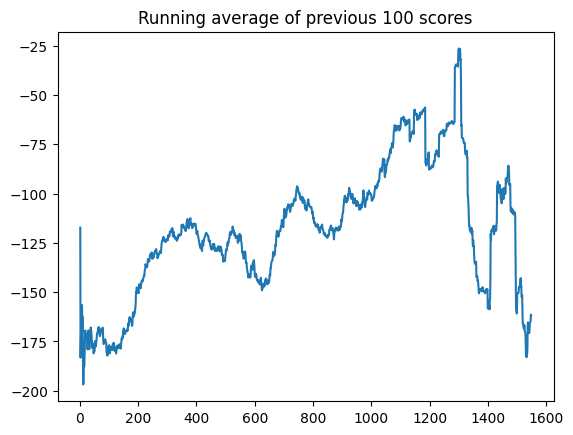

In [26]:
fname = 'REINFORCE_' + 'lunar_lunar_lr' + str(agent.lr) + '_' \
            + str(n_games) + 'games'
figure_file =  fname + '.png'

x = [i+1 for i in range(len(scores))]
plot_learning_curve(scores, x, figure_file)